# Классификация дефектов кожи

In [1]:
#!pip install -q tensorflow==2.3
#!pip install keras_efficientnets
#!pip freeze > requirements.txt

# Импортируем библиотеки 

In [2]:
# Импортируем библиотеки

import pandas as pd # импортируем необходимые библиотеки
import numpy as np
import re
import random
import os
import sys
import PIL
import cv2

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import ExtraTreeRegressor
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 

from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import itertools 

#from catboost import CatBoostRegressor

from tqdm import tqdm
from tqdm.notebook import tqdm

from itertools import combinations
from scipy.stats import ttest_ind


# # keras
import tensorflow as tf
from tensorflow import keras
#import tensorflow.keras.layers as L
#from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#import albumentations
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
#from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
#import tensorflow as tf
import tensorflow.keras 
import tensorflow.keras.models #as M
#import tensorflow.keras.layers as L
#import tensorflow.keras.backend #as K
from tensorflow.keras import optimizers

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from glob import glob
from glob import iglob
#from keras.applications import InceptionV3
#from keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense ,LeakyReLU,GlobalAveragePooling2D, BatchNormalization,GlobalMaxPool2D, Convolution2D

import nltk
from nltk.corpus import stopwords

# plt
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
#DATA_PATH = "/content/drive/My Drive/cars2/"
#PATH = "/content/"  # рабочая директория

In [3]:
#from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import EfficientNetB4
print(keras.__version__)
print(tf.__version__)

2.4.0
2.4.0


In [4]:
print(tf.__version__)

2.4.0


In [5]:
from tensorflow.keras.applications import InceptionV3

In [6]:
keras.applications.EfficientNetB4()

78872576/78864416 [==============================] - 1s 0us/step


In [7]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 21:08:20) 
Numpy        : 1.19.5
Tensorflow   : 2.4.0


# Задаем константы

In [8]:
train_path = "/kaggle/input/dermnet/train/"
test_path = "/kaggle/input/dermnet/test/"

In [9]:
RANDOM_SEED = 42
IMAGE_SIZE         = (299, 299)
#INPUT_SHAPE        = (224, 224, 3)
IMG_SIZE           = 299 # размер входного изображения для Xception по-умолчанию
IMG_CHANNELS       = 3   # у RGB 3 канала
input_shape        = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
# Keras settings
BATCH_SIZE = 6
VAL_BATCH_SIZE = 8
VAL_SPLIT          = 0.2 # сколько данных выделяем на тест = 15%
EPOCHS = 12
LR = 0.00001

# Предобработка изображений: просмотр, аугментация, создание обучающего и тестового наборов

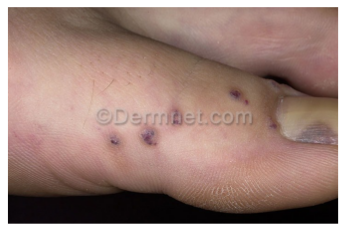

In [26]:
# Посмотрим пример картинки

img = PIL.Image.open(train_path + "Vascular Tumors/angiokeratomas-18.jpg") # load_img(train_path + "nevus/ISIC_0000041.jpg")
plt.imshow(img)
plt.axis("off")
plt.show()


In [27]:
# Преобразуем картинку в массив

x = img_to_array(img)
print(x.shape)
x

(472, 720, 3)


array([[[123.,  99.,  87.],
        [113.,  89.,  77.],
        [115.,  91.,  79.],
        ...,
        [102.,  75.,  58.],
        [100.,  73.,  56.],
        [ 98.,  71.,  54.]],

       [[122.,  98.,  86.],
        [122.,  98.,  86.],
        [114.,  90.,  78.],
        ...,
        [103.,  76.,  59.],
        [103.,  76.,  59.],
        [102.,  75.,  58.]],

       [[119.,  95.,  83.],
        [130., 106.,  94.],
        [117.,  93.,  81.],
        ...,
        [106.,  77.,  61.],
        [107.,  78.,  62.],
        [108.,  79.,  63.]],

       ...,

       [[ 12.,   7.,  11.],
        [ 12.,   7.,  11.],
        [ 12.,   7.,  11.],
        ...,
        [  3.,   1.,   2.],
        [  3.,   1.,   2.],
        [  3.,   1.,   2.]],

       [[ 12.,   7.,  11.],
        [ 12.,   7.,  11.],
        [ 13.,   8.,  12.],
        ...,
        [  3.,   1.,   2.],
        [  3.,   1.,   2.],
        [  3.,   1.,   2.]],

       [[ 12.,   7.,  11.],
        [ 12.,   7.,  11.],
        [ 13.,  

In [28]:
# C помощью glob определяем сколько разных папок с картинками имеется.

className = glob(train_path + '/*' )
numberOfClass = len(className)
print("NumberOfClass: ",numberOfClass)

NumberOfClass:  23


## Аугментация с помощью ImageDataGenerator (выполняется либо этот раздел аугментации, либо следующий )

In [ ]:
# Аугментация обучающего датасета
# Официальная документация: https://keras.io/preprocessing/image/

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 60,
    brightness_range = [0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=[0.75,1.25],
    fill_mode='reflect')  #  fill_mode='nearest'

       
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
# Завернем наши данные в генератор.

train_generator = train_datagen.flow_from_directory(
    train_path,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation') # set as validation data


In [ ]:
test_val_generator = test_datagen.flow_from_directory(
    directory=test_path,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)


In [ ]:
train_generator

## Аугментация с помощью albumentations (выполняется либо этот раздел аугментации, либо предыдущий)

In [13]:
!pip install albumentations

In [14]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-_85uh_ze
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-_85uh_ze
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=0f4df1494eb296e9d84da8492eaf034826bcfa92da0b720fd2dcec94cbbfc101
  Stored in directory: /tmp/pip-ephem-wheel-cache-hh_44efc/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor


In [15]:
import albumentations
import cv2
from ImageDataAugmentor.image_data_augmentor import *
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

In [16]:
# попробовать

AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(), #0.5
    albumentations.Rotate(limit=40),
    albumentations.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
    albumentations.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RandomContrast(limit=0.2, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )

      
test_datagen = ImageDataAugmentor(rescale=1./255)

val_datagen = ImageDataAugmentor(rescale=1. / 255, validation_split=VAL_SPLIT)

In [ ]:
# Аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.


AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5), #0.5
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=299, width=299),
        albumentations.CenterCrop(height=299, width=299),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
   # albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )

      
test_datagen = ImageDataAugmentor(rescale=1./255)

val_datagen = ImageDataAugmentor(rescale=1. / 255, validation_split=VAL_SPLIT)

In [17]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    train_path,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data



/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 12453 images belonging to 23 classes.
Found 3104 images belonging to 23 classes.


In [18]:
test_val_generator = test_datagen.flow_from_directory(
    directory=test_path,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 4002 images belonging to 23 classes.


Пример картинок из train_generator


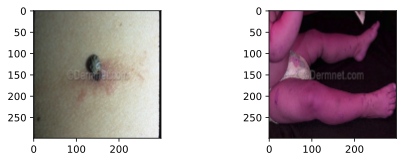

In [19]:
# Прсмотрим несколько картинок после применения аугментации.

from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,2):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

In [20]:
imgs, labels = next(train_generator)
print(imgs.shape, labels.shape)

(6, 299, 299, 3) (6, 23)


# Посмотрим распределение данных по классам.

In [21]:

def classes_count (path):
    # определяет содержимое папок классов
    
    classes = []
    for filename in iglob(os.path.join(train_path, "**","*.jpg")):
        classes.append(os.path.split(os.path.split(filename)[0])[-1])
    cnt = Counter(classes)
    return cnt

def percentage_value(pct, allvals):
    # вычисляет процентное значение размера класса
    
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

def plot_dataset_description(path, title):
    # строит круговую диаграмму
    
    classes_cnt = classes_count(path)
    values = list(classes_cnt.values())
    labels = list(classes_cnt.keys())

    plt.figure(figsize=(8,8))
    plt.pie(values, labels=labels, autopct=lambda pct: percentage_value(pct, values), 
            shadow=True, startangle=140)

    plt.title(title)    
    plt.show()

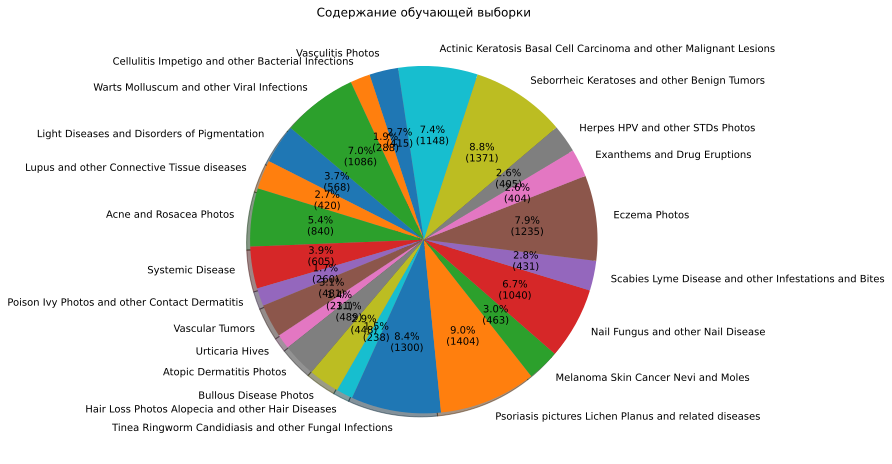

In [22]:
plot_dataset_description(os.path.join(train_path), "Содержание обучающей выборки")

In [ ]:
plot_dataset_description(os.path.join(test_path), "Содержание тестовой выборки")

In [ ]:
def plot_dataset_description_bar(path, title):
    # строит диаграмму столбиками
 
    classes_val = classes_count(path)
    

    values = list(classes_val.values())
    labels = list(classes_val.keys())

    index = [n for n in range(numberOfClass)]
    plt.figure(figsize=(10, 5))
    #hist, bins = np.histogram(values, bins=9)
    plt.bar(values, values, width=10)
    
    #plt.xlabel('Градация болезней', fontsize=10)
    plt.ylabel('Количество картинок', fontsize=10)
    plt.xticks(values, labels, fontsize=8, rotation=90)
    plt.title(title)

In [ ]:
plot_dataset_description_bar(os.path.join(train_path), 'Содержание примеров в обучающей выборке')

# t-SNE

In [ ]:
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

In [ ]:
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

In [ ]:
datasets.info()

In [ ]:
n_samples = 300
n_components = 2
(fig, subplots) = plt.subplots(1, 5, figsize=(15, 2.5))

In [ ]:

n_samples = 300
n_components = 3
(fig, subplots) = plt.subplots(3, 5, figsize=(15, 8))
perplexities = [5, 30, 50, 100]

X, y = datasets.make_circles(n_samples=x, factor=.5, noise=.05)

red = y == 0
green = y == 1

ax = subplots[0][0]
ax.scatter(X[red, 0], X[red, 1], c="r")
ax.scatter(X[green, 0], X[green, 1], c="g")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

for i, perplexity in enumerate(perplexities):
    ax = subplots[0][i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[red, 0], Y[red, 1], c="r")
    ax.scatter(Y[green, 0], Y[green, 1], c="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

# Another example using s-curve
X, color = datasets.make_s_curve(n_samples, random_state=0)

ax = subplots[1][0]
ax.scatter(X[:, 0], X[:, 2], c=color)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

for i, perplexity in enumerate(perplexities):
    ax = subplots[1][i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("S-curve, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')


# Another example using a 2D uniform grid
x = np.linspace(0, 1, int(np.sqrt(n_samples)))
xx, yy = np.meshgrid(x, x)
X = np.hstack([
    xx.ravel().reshape(-1, 1),
    yy.ravel().reshape(-1, 1),
])
color = xx.ravel()
ax = subplots[2][0]
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

for i, perplexity in enumerate(perplexities):
    ax = subplots[2][i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("uniform grid, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')


plt.show()

# Построение модели.

In [ ]:
def modelXception():
    
    model = Sequential()
    model.add(Xception(include_top = False, weights = "imagenet",  # Xception ResNet50 VGG19 NASNetLarge InceptionResNetV2  InceptionV3 28 EfficientNetB4
                            input_shape=(IMG_SIZE,IMG_SIZE, 3)))
    #model.add(GlobalAveragePooling2D())
    #model.add(BatchNormalization())   # переобучение
    ###model.add(Dense(128, activation = 'relu'))
    ##model.add(LeakyReLU(0.0001))
    ##model.add(Dropout(0.2))
    ###model.add(BatchNormalization())
    #model.add(Dense(256, activation='relu'))
    model.add(GlobalMaxPool2D())  
    model.add(Dropout(0.5))
    model.add(Dense(numberOfClass, activation = "softmax"))
    
    return model 

In [ ]:
def modelXception():
    model = Sequential()
#img_input = Input(shape= (192, 256, 3))
    model.add(Conv2D(16, (5, 5), input_shape=input_shape, activation='relu', padding='same',))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same')
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, (4, 4), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (4, 4), padding='same', name='conv4')
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())

    model.add(Dropout(0.5))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dense(1024, activation = 'relu'))
# Deconvolution Layers (BatchNorm after non-linear activation)

    model.add(Conv2DTranspose(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(256, (3, 3), padding='same'))
    model.add( BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2DTranspose(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(1, (3, 3), padding='same'))
    model.add(BatchNormalization())

    model.add(Dropout(0.5))

    model.add(Dense(numberOfClass, activation = "softmax"))
    return model          

In [29]:
def modelXception():
    model = Sequential()

# model layer 1
    model.add(Convolution2D(128, (3, 3), input_shape=input_shape, activation='relu', padding='same',))
    model.add(BatchNormalization())
    model.add(Convolution2D(128, (3, 3), activation='relu', padding='same',))
    model.add(BatchNormalization())

# Pooling layer 1
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

# model and pooling layer 2
    model.add(Convolution2D(256, (3, 3), activation='relu', padding='same',))
    model.add(BatchNormalization())
    model.add(Convolution2D(256, (3, 3), activation='relu', padding='same',))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

# model and pooling layer 3.
    model.add(Convolution2D(512, (3, 3), activation='relu', padding='same',))
    model.add(BatchNormalization())
    model.add(Convolution2D(512, (3, 3), activation='relu', padding='same',))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))


# Flattening
    model.add(Flatten())

# Full connection
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(numberOfClass, activation='softmax'))
    return model 

In [ ]:
# попробовать эту с подгрузкой весов
def modelXception():
    
    model =EfficientNetB4(include_top=False, input_shape=(128,128,3), weights=None, pooling='avg')
    EfficientNet = "../input/tfkerasefficientnetimagenetnotop/efficientnetb4_notop.h5"
    model.load_weights(EfficientNet)

    model = models.Sequential()
    model.add(layers.GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(9, activation = "softmax"))
    return model 

In [24]:
numberOfClass
#MaxPooling2D()

23

In [ ]:
imgs, labels = next(test_generator)
print(imgs.shape, labels.shape)

In [ ]:
imgs, labels = next(train_generator)
print(imgs.shape, labels.shape)

In [30]:
model = modelXception()

In [ ]:
from tensorflow.keras import utils

utils.plot_model(model)

In [ ]:
#model = Sequential()
#model.add(InceptionV3(include_top=False, weights='imagenet',input_shape=(3,299,299)))
#model.add(Flatten(input_shape=(3,299,299)[1:]))
#model.add(Dense(32))
#model.add(LeakyReLU(0.001))
#model.add(Dense(16))
#model.add(LeakyReLU(0.001))
#model.add(Dense(numberOfClass, activation='softmax'))
#model.layers[0].trainable = False1129, 1504, 3)

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
#model.summary()

In [31]:
# CallBack для сохранения модели, ее весов и лучшей модели
weightpath = "best_model.hdf5"
checkpoint = ModelCheckpoint(weightpath , monitor = 'val_accuracy' , mode = 'max', verbose = 1,save_best_only=True) #save_weights_only=True, save_best_only=True,
#checkpoint = ModelCheckpoint(weightpath , monitor = ['val_accuracy'] , save_best_only=True)
reducer = ReduceLROnPlateau(monitor='loss', patience= 8,factor=0.2, min_lr=0.00000001,  verbose = 1, cooldown=3, mode='auto', min_delta=0.0001) #min_delta=0.000000001
early_stop= EarlyStopping(monitor='loss',patience= 10, mode='min')  #min_delta=0.000000001
#early_stop= EarlyStopping(monitor='val_accuracy',patience= 10, restore_best_weights=True)

In [32]:
# EarlyStopping для остановки обучения, когда отслеживаемый показатель перестал улучшаться.

#early_stop= EarlyStopping(min_delta=0.001, verbose=1, mode="max", restore_best_weights=False) #  patience=7,

#callbacks_list = [checkpoint] #, early_stop]
callbacks_list = [checkpoint, reducer, early_stop]

In [33]:
# Компилируем модель.

model.compile(optimizer=optimizers.Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
len(train_generator)

2076

In [ ]:
train_generator.samples

# Обучаем модель.

In [ ]:
%%time
history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 8, #EPOCHS,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
2076/2076 [==============================] - 536s 255ms/step - loss: 11.9614 - accuracy: 0.0821 - val_loss: 9.6041 - val_accuracy: 0.0515

Epoch 00001: val_accuracy improved from -inf to 0.05155, saving model to best_model.hdf5
Epoch 2/8
2076/2076 [==============================] - 515s 248ms/step - loss: 3.2333 - accuracy: 0.0846 - val_loss: 3.0904 - val_accuracy: 0.0912

Epoch 00002: val_accuracy improved from 0.05155 to 0.09117, saving model to best_model.hdf5


In [ ]:
#print("Straturi:")
#for i, layer in enumerate(model.layers[:30]):
#    print(i, layer.name)
#    layer.trainable = False

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
history=model.save('model_last.hdf5')

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], 'b*-', label="training acc")
plt.plot(history.history['val_accuracy'], 'r*-', label="validation acc")
plt.grid()
plt.title("train_acc vs val_acc")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], 'b*-', label="training loss")
plt.plot(history.history['val_loss'], 'r*-', label="validation loss")
plt.grid()
plt.title("Training and validation loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# Результаты

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
scores = model.evaluate_generator(test_val_generator, steps=len(test_val_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
scores

In [ ]:
scores2 = model.predict(test_val_generator)  #np.argmax(probabilities)

In [ ]:
scores2

In [ ]:
scores = model.evaluate_generator(scores2, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

## Confugn matrix по тестовым данным

In [ ]:
%%time
Y_pred = model.predict_generator(test_generator,verbose=1)  # test_val_generator
Y_pred

In [ ]:
y_pred2 = np.argmax(Y_pred, axis=1)
y_pred2

In [ ]:
cnf_matrix = confusion_matrix(test_generator.classes, y_pred2)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12,12))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

In [ ]:
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

In [ ]:
list(classes.values())

In [ ]:
plot_confusion_matrix(cnf_matrix, list(classes.values()))

In [ ]:
# классификация ответов

print(classification_report(test_generator.classes, y_pred2, target_names=list(classes.values())))

In [ ]:
# Confugn matrix по валидационным данным

In [ ]:
%%time
Y_pred1 = model.predict_generator(test_val_generator,verbose=1)  # test_val_generator
y_pred_val = np.argmax(Y_pred1, axis=1)
y_pred_val

In [ ]:
cnf_matrix_val = confusion_matrix(test_val_generator.classes, y_pred_val)
classes = {v: k for k, v in test_val_generator.class_indices.items()}
print(classes)

In [ ]:
plot_confusion_matrix(cnf_matrix_val, list(classes.values()))

In [ ]:
# классификация ответов

print(classification_report(test_val_generator.classes, y_pred_val, target_names=list(classes.values())))

# Tестовая демонстрация.

In [ ]:
def load_image(filename):
    # загружает картинку
    
    img = cv2.imread(os.path.join(train_path, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    return img

def predict(image):
    # возвращает первые три максимальных значений из предсказанных для каждого класса
    
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = (-probabilities).argsort()[:3]  # np.argmax(probabilities)
    return class_idx, probabilities[class_idx]

In [ ]:
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

In [ ]:
img2=load_image(train_path + 'Vascular Tumors/angiokeratomas-18.jpg')

In [ ]:
img3=np.asarray([img2])
img3

In [ ]:
pr = model.predict(img3)[0]

In [ ]:
pr[idx]

In [ ]:
class_idx1 = np.argmax(pr)
class_idx1

In [ ]:
for idx, filename in enumerate(random.sample(test_generator.filenames, 3)):    # test_val_generator
    print("Источник: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[prediction[0][0]], prediction[1][0]))
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[prediction[0][1]], prediction[1][1]))
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[prediction[0][2]], prediction[1][2]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

# Сохранение модели для продакшн

In [ ]:
channel.queue_declare(queue='Features')

In [ ]:
def callback(ch, method, properties, body):
    print(f'Получен вектор признаков {body}')

In [ ]:
# on_message_callback показывает какую функцию вызвать при получении сообщения
channel.basic_consume(
    queue='Features', on_message_callback=callback, auto_ack=True)
print('...Ожидание сообщений, для выхода нажмите CTRL+C')

In [ ]:
channel.start_consuming()

In [ ]:
import pika
      ___(1)___
connection = ___(2)___(
    pika.ConnectionParameters(host='localhost'))
      ___(3)___ = connection.channel()

channel.queue_declare(queue='y_true')
channel.queue_declare(___(4)___)

def ___(5)___(ch, method, ___(6)___, body):
    print(f'Из очереди {method.routing_key} получено значение {json.loads(___(7)___)}')

channel.basic_consume(
    queue='y_predict', on_message_callback=callback, auto_ack=True)

channel.basic_consume(
      queue=___(8)___, on_message_callback=callback, auto_ack=True)

print('...Ожидание сообщений, для выхода нажмите CTRL+C')
      channel.___(9)___()

In [ ]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.color import rgb2grey
from sklearn.feature_extraction import image
from sklearn.cluster import KMeans
from skimage.filters import rank, threshold_otsu
from skimage.morphology import closing, square, disk
from skimage import exposure as hist, data, img_as_float
from skimage.segmentation import chan_vese
from skimage.feature import canny
from skimage.color import rgb2gray
from scipy import ndimage as ndi 

In [ ]:
mal_images = glob('../input/dermnet/train/Eczema Photos/*' )
ben_images = glob('../input/dermnet/train/Bullous Disease Photos/*')

mal_images1 = glob('../input/dermnet/train/Eczema Photos/*' )[:5]
ben_images1 = glob('../input/dermnet/train/Bullous Disease Photos/*')[:5]

In [ ]:
#https://www.sciencedirect.com/topics/engineering/binary-image
def binary(image):
    return image > threshold_otsu(image)

#https://campus.datacamp.com/courses/introduction-to-data-visualization-in-python/analyzing-time-series-and-images?ex=13
def equalize(image):
    return hist.equalize_hist(image)

#https://homepages.inf.ed.ac.uk/rbf/HIPR2/median.htm
def mean_filter(image, raio_disk):
    return rank.mean_percentile(image, selem = disk(raio_disk))

def preenche_bords(image):
    return ndi.binary_fill_holes(image)

#https://www.unioviedo.es/compnum/labs/PYTHON/intro_image.html

def load_images(paths):
    tmp = []
    for path in paths:
        tmp.append(imread(path))
    return tmp
    
def plot_any(arr, title = ''):
    plt.figure(figsize = (15, 25))
    for i in range(len(arr)):
        plt.subplot(1,len(arr),i + 1)
        plt.title(title)
        plt.imshow(arr[i]);

        
def plot_camadas(img):
    plt.figure(figsize = (15, 25))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img[:,:,i], cmap = 'gray');
        
def d2Kmeans(img, k):
    return KMeans(n_jobs=-1, 
                  random_state=1, 
                  n_clusters = k, 
                  init='k-means++'
    ).fit(img.reshape((-1,1))).labels_.reshape(img.shape)

def merge_segmented_mask_ROI(uri_img, img_kluster):
    new_img = uri_img.copy()
    for ch in range(3):
        new_img[:,:, ch] *= img_kluster
    return new_img


def elbow(img, k):
    hist = []
    for kclusters in  range(1, k):
        Km = KMeans(n_jobs=-1, random_state=1, n_clusters = kclusters, init='k-means++').fit(img.reshape((-1,1)))  
        hist.append(Km.inertia_)
        
    plt.figure(figsize = (15, 8))
    plt.grid()
    plt.plot(range(1, k), hist, 'o-')
    plt.ylabel('Soma das distâncias quadradas')
    plt.xlabel('k clusters')
    plt.title('Elbow')
    plt.show();

In [ ]:
mal = load_images(mal_images)
ben = load_images(ben_images)

mal_1 = load_images(mal_images1)
ben_1 = load_images(ben_images1)

In [ ]:
plot_any(mal_1)
plot_any(ben_1)

In [ ]:
img_selected = mal[1]

In [ ]:
elbow(img_selected, 6)

In [ ]:
k_klusters = 23

In [ ]:
result_gray = d2Kmeans(rgb2grey(img_selected), k_klusters)
result_img = d2Kmeans(img_selected, k_klusters)

In [ ]:
klusters_gray = [result_gray == i for i in range(k_klusters)]
plot_any(klusters_gray)


In [ ]:
def select_cluster_index(clusters):
    minx = clusters[0].mean()
    index = 0
    for i in clusters:
        if i.mean() < minx:
            minx = i.mean()
            index += 1
    return index

In [ ]:
index_kluster = select_cluster_index(klusters_gray)
print(index_kluster)
selecionado = klusters_gray[index_kluster]

In [ ]:
 for ch in range(3):
    img_k = []
    for K in range(k_klusters):
         img_k.append(result_img[:, :, ch] == K)
    plot_any(img_k)

In [ ]:
clusters = [(result_img[:,:,1] == K) for K in range(k_klusters)]
clusters

In [ ]:
new_img = merge_segmented_mask_ROI(img_selected, selecionado)

In [ ]:
plot_any([new_img])

In [ ]:
image_mean_filter = mean_filter(selecionado, 20)
#test_binary = binary(image_mean_filter)

In [ ]:
plot_any([selecionado, image_mean_filter, test_binary])

In [ ]:
final_result = merge_segmented_mask_ROI(img_selected ,test_binary)

In [ ]:
final_result.shape

In [ ]:
plot_any([test_binary, new_img, final_result])

In [ ]:
max_mean = 0
img_gray = rgb2gray(final_result)
img_bin  = binary(img_gray)
x, y = img_bin.shape

limits_before = []
for i in range(x):
    for j in range(y):
        if  img_bin[i, j]:
            limits_before.append(j)
            
stop_before = ( sum(limits_before) // len(limits_before) ) // 2
img_copy = img_bin.copy()
for i in range(x):
    for j in range(stop_before):
        img_copy[i, j] = 0
        limits_after = []
for i in range(x):
     for j in range(y - 1, 0, -1):
        if  img_copy[i, j]:
            limits_after.append(j)
            
stop_after = sum(limits_after) // len(limits_after) + min(limits_after)
for i in range(x):
    for j in range(stop_after, y):
        img_copy[i, j] = 0

mean_result = mean_filter(img_copy, 15)
mean_result = binary(mean_result)
#final_result = merge_segmented_mask_ROI(img_selected , mean_result)


plot_any([mean_result, final_result])

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
img = cv2.imread(mal_images[1]) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
r, g, b = cv2.split(img)
r = r.flatten()
g = g.flatten()
b = b.flatten()
#plotting 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(r, g, b)
plt.show()

In [ ]:
data_mal = list() 
for img in mal :
    img = merge_segmented_mask_ROI(img ,test_binary)
    data_mal.append(img)

In [ ]:
data_ben = list() 
for img in ben :
    img = merge_segmented_mask_ROI(img ,test_binary)
    data_ben.append(img)

In [ ]:
len(data_ben)
len(data_mal)

In [ ]:
import cv2
import os
import io
import skimage
# create a directory in which to store cropped images
out_dir = "/kaggle/working/skin_seg"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# save each cropped image by its index number
for k,im in enumerate(data_ben):
    skimage.io.imsave( 'ben' + str(k) + ".jpg", im)  

In [ ]:
# create a directory in which to store cropped images
out_dir = "‪/kaggle/working/skin_seg"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# save each cropped image by its index number
for c,image in enumerate(data_mal):
    skimage.io.imsave( 'mal' + str(c) + ".jpg", image)

In [ ]:
plt.imshow(data_ben[1],cmap = 'hot')

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split

from skimage.io import imread
from skimage.transform import resize

In [ ]:
def load_image_files(container_path, dimension=(28, 28)):
    """
    Load image files with categories as subfolder names 
    which performs like scikit-learn sample dataset
    
    Parameters
    ----------
    container_path : string or unicode
        Path to the main folder holding one subfolder per category
    dimension : tuple
        size to which image are adjusted to
        
    Returns
    -------
    Bunch
    """
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    images = []
    flat_data = []
    target = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            img = skimage.io.imread(file)
            img_resized = resize(img, dimension, anti_aliasing=True, mode='reflect')
            flat_data.append(img_resized.flatten()) 
            images.append(img_resized)
            target.append(i)
    flat_data = np.array(flat_data)
    target = np.array(target)
    images = np.array(images)
    images.reshape((-1, 1, 28, 28))

    return Bunch(data=flat_data,
                 target=target,
                 target_names=categories,
                 images=images,
                 DESCR=descr)

In [ ]:
image_dataset = load_image_files("../input/segmented-images-of-the-skin-cancer-dataset/")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    image_dataset.data, image_dataset.target, test_size=0.3,random_state=109)

In [ ]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
print(clf)

In [ ]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [ ]:
from sklearn.model_selection import train_test_split

clf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score
preds = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test,preds))

In [ ]:
print(X_train.shape)
print(X_test.shape )
print(y_train.shape )
print(y_test.shape) 

In [ ]:
x_train, x_test, y_train_v, y_test_v = train_test_split(X_train,y_train, test_size = 0.3, random_state = 2)

In [ ]:
rf = RandomForestClassifier()

rf.fit(x_train,y_train_v)
# Predictions on training and validation
y_pred_train = rf.predict(x_train)
    # predictions for test
y_pred_test = rf.predict(x_test)
    # training metrics
print("Training metrics:")
print(sklearn.metrics.classification_report(y_true= y_train_v, y_pred= y_pred_train))
    
    # test data metrics
print("Test data metrics:")
print(sklearn.metrics.classification_report(y_true= y_test_v, y_pred= y_pred_test))

In [ ]:
print(rf.classes_)

In [ ]:
from PIL import Image
import time
from torch.autograd import Variable
import json
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
from PIL import Image
from collections import OrderedDict
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

from skimage.transform import resize

In [ ]:
img_path="../input/segmented-images-of-the-skin-cancer-dataset/benign_segmented/ben1.jpg"
img_ = cv2.imread(img_path, cv2.IMREAD_COLOR)
img_ = cv2.resize(img_, (28, 28))
img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2BGR)
plt.imshow(img_)

In [ ]:
метод 2

In [ ]:
!pip install mahotas
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import mahotas
import cv2
import os
import h5py
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# make a fix file size
fixed_size  = tuple((1000,1000))

#train path 
train_path = "../input/segmented-images-of-the-skin-cancer-dataset/"

# no of trees for Random Forests
num_tree = 100

# bins for histograms 
bins = 8

# train_test_split size
test_size = 0.10

# seed for reproducing same result 
seed = 9

In [ ]:
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [ ]:
# feature-descriptor -2 Haralick Texture 

def fd_haralick(image):
    # conver the image to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # Ccompute the haralick texture fetature ve tor 
    haralic = mahotas.features.haralick(gray).mean(axis=0)
    return haralic

In [ ]:
# feature-description -3 Color Histogram

def fd_histogram(image, mask=None):
    # conver the image to HSV colors-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #COPUTE THE COLOR HISTPGRAM
    hist  = cv2.calcHist([image],[0,1,2],None,[bins,bins,bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist,hist)
    # return the histog....
    return hist.flatten()

In [ ]:
# get the training data labels 
train_labels = os.listdir(train_path)

# sort the training labesl 
train_labels.sort()
print(train_labels)

# empty list to hold feature vectors and labels 
global_features = []
labels = []

i, j = 0, 0 
k = 0

# num of images per class 
images_per_class = 80

In [ ]:
# ittirate the folder to get the image label name

%time
# lop over the training data sub folder 

for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    k = 1
    # loop over the images in each sub-folder
        
    for file in os.listdir(dir):

        file = dir + "/" + os.fsdecode(file)
       
        # read the image and resize it to a fixed-size
        image = cv2.imread(file) 
        
        if image is not None:
            image = cv2.resize(image,fixed_size)
            fv_hu_moments = fd_hu_moments(image)
            fv_haralick   = fd_haralick(image)
            fv_histogram  = fd_histogram(image)
        #else:
            #print("image not loaded")
                
        #image = cv2.imread(file)        
        #image = cv2.resize(image,fixed_size)

        # Concatenate global features
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

        i += 1
        k += 1
    print("[STATUS] processed folder: {}".format(current_label))
    j += 1

print("[STATUS] completed Global Feature Extraction...")

In [ ]:
%time
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print("[STATUS] training labels encoded...{}")
# normalize the feature vector in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

In [ ]:
global_features = np.array(rescaled_features)
global_labels = np.array(target)

In [ ]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

In [ ]:
import sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=100)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

#print(clf.fit(trainDataGlobal, trainLabelsGlobal))

clf_pred = clf.predict(trainDataGlobal)
#clf_pred = clf.predict(global_feature.reshape(1,-1))[0]
print(classification_report(trainLabelsGlobal,clf_pred))
y_pred_test = clf.predict(testDataGlobal)

print(classification_report(testLabelsGlobal,y_pred_test))
#print(confusion_matrix(trainLabelsGlobal,clf_pred))

#print(clf.predict(trainDataGlobal))

#print(clf.predict(global_feature.reshape(1,-1))[0])

In [ ]:
# path to test data
test_path = "../input/segmented-images-of-the-skin-cancer-dataset/benign_segmented/ben1.jpg"


    #print(file)
    
    # read the image
image = cv2.imread(test_path)

    # resize the image
image = cv2.resize(image, fixed_size)

    # Global Feature extraction
fv_hu_moments = fd_hu_moments(image)
fv_haralick   = fd_haralick(image)
fv_histogram  = fd_histogram(image)

    # Concatenate global features

global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

    # predict label of test image
prediction = clf.predict(global_feature.reshape(1,-1))[0]

    # show predicted label on image
cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()